# Hand Gesture Classification using EMG

**EMG Pattern Classification**

For recording patterns, the authors (1) used a MYO Thalmic bracelet worn on a user’s forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with **eight sensors** equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC. 


    Author: Debanjan Saha
    College: Northeastern University
    Group: Project Group 7
    Batch: Wednesday
    Course: IE 7300
    Professor: Ramin M.

This dataset contains raw EMG data for **36** subjects while they performed series of static hand gestures.The subject performs two series, each of which consists of **six (seven) basic gestures**. Each gesture was **performed for 3 seconds** with a **pause** of **3 seconds between gestures**.

**Relevant Papers**:
1. Lobov S., Krilova N., Kastalskiy I., Kazantsev V., Makarov V.A. Latent Factors Limiting the Performance of sEMG-Interfaces. Sensors. 2018;18(4):1122. doi: 10.3390/s18041122

2. Côté Allard, Ulysse & Fall, C. L. & Campeau-Lecours, Alexandre & Gosselin, Clément & Laviolette, Francois & Gosselin, Benoit. (2017). Transfer Learning for sEMG Hand Gesture Recognition Using Convolutional Neural Networks. 10.1109/SMC.2017.8122854.


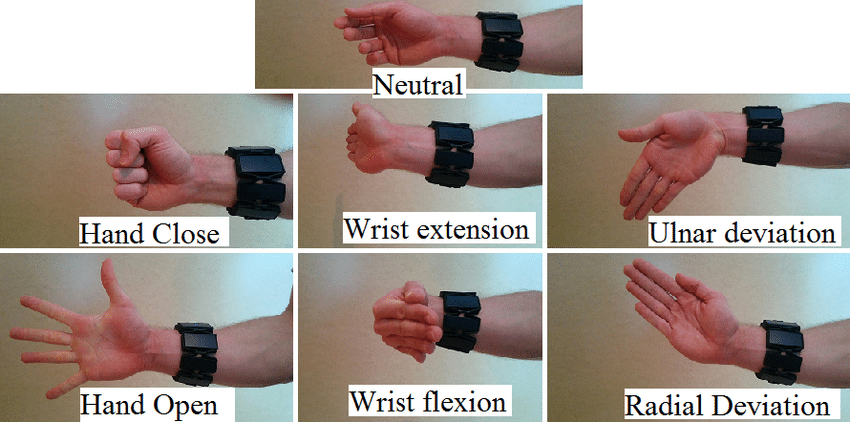

Image Source: Allard et. al (2)

## Import Libraries

In [2]:
#!pip install nolds
!pip install pycatch22
#!pip install torchsummary
# !pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.2-cp39-cp39-linux_x86_64.whl size=118684 sha256=07551945bb30848556b22338e92da63f0599044d5e67158d01709075d6d022e8
  Stored in directory: /root/.cache/pip/wheels/c0/84/da/f210e9de22c6265163dac19287b0674e040605dfc519d83ca5
Successfully built pycatch22


In [1]:
import warnings
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import pywt
# import librosa
# import nolds
# import pyeeg
# warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
from numpy.lib.stride_tricks import sliding_window_view
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 500)

In [3]:
import statistics
from scipy import stats
# from scipy.fft import rfft, rfftfreq
# from scipy.signal import butter, filtfilt
import pycatch22
# import tensorflow as tf
# from tensorflow import keras
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import TensorDataset, DataLoader
# from torchsummary import summary

In [4]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master'
!ls -lrt

/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master
total 146
-rw------- 1 root root 1453 Dec  7  2018 README.txt
drwx------ 2 root root 4096 Apr  2 17:32 25
drwx------ 2 root root 4096 Apr  2 17:32 24
drwx------ 2 root root 4096 Apr  2 17:32 23
drwx------ 2 root root 4096 Apr  2 17:32 22
drwx------ 2 root root 4096 Apr  2 17:32 15
drwx------ 2 root root 4096 Apr  2 17:32 14
drwx------ 2 root root 4096 Apr  2 17:32 13
drwx------ 2 root root 4096 Apr  2 17:32 12
drwx------ 2 root root 4096 Apr  2 17:32 06
drwx------ 2 root root 4096 Apr  2 17:32 01
drwx------ 2 root root 4096 Apr  2 17:32 36
drwx------ 2 root root 4096 Apr  2 17:32 31
drwx------ 2 root root 4096 Apr  2 17:32 30
drwx------ 2 root root 4096 Apr  2 17:32 26
drwx------ 2 root root 4096 Apr  2 17:32 21
drwx------ 2 root root 4096 Apr  2 17:32 19
drwx------ 2 root root 4096 Apr  2 17:32 10
drwx------ 2 root root 4096 Apr  2 17:32 09
drwx------ 2 root root 4096 Apr  2 17:32 08
drwx------ 2 

## Read Data

In [6]:
# List out all the available files in the project's environment
files_path = set()
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/'):
    for filename in filenames:
        f_path = os.path.join(dirname, filename)
        files_path.add(f_path)

In [7]:
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/README.txt')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/.DS_Store')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/all_ext_features_data.csv')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/Segmented_Catch22_Subject1.csv')
files_path

{'/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/1_raw_data_09-32_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/2_raw_data_09-34_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/1_raw_data_18-02_24.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/2_raw_data_18-03_24.04.1

In [8]:
all_train = pd.DataFrame()
all_test = pd.DataFrame()
for id, file in enumerate(tqdm(sorted(files_path))):
    
    sub = int(file.split('/')[-2])
    data = pd.read_csv(file, sep='\t')
    subject_id = np.ones([len(data),1], dtype=np.int16)*sub
    print('\tSubject Id: \t', sub, '\tShape: ', subject_id.shape)
    # Add the subject into the data
    data['subject_id'] = subject_id
    if id%2 == 1: 
        all_train = pd.concat([all_train, data], axis=0, ignore_index=True, copy=True)
    else:
        all_test = pd.concat([all_test, data], axis=0, ignore_index=True, copy=True)

print('Total Training Records: ', all_train.shape)
print('Total Testing Records: ', all_test.shape)

  1%|▏         | 1/72 [00:00<00:32,  2.16it/s]

	Subject Id: 	 1 	Shape:  (63196, 1)


  3%|▎         | 2/72 [00:00<00:28,  2.43it/s]

	Subject Id: 	 1 	Shape:  (57974, 1)


  4%|▍         | 3/72 [00:01<00:29,  2.30it/s]

	Subject Id: 	 2 	Shape:  (72322, 1)


  6%|▌         | 4/72 [00:01<00:28,  2.43it/s]

	Subject Id: 	 2 	Shape:  (64104, 1)


  7%|▋         | 5/72 [00:02<00:26,  2.53it/s]

	Subject Id: 	 3 	Shape:  (56568, 1)


  8%|▊         | 6/72 [00:02<00:26,  2.45it/s]

	Subject Id: 	 3 	Shape:  (49217, 1)


 10%|▉         | 7/72 [00:02<00:26,  2.45it/s]

	Subject Id: 	 4 	Shape:  (59107, 1)


 11%|█         | 8/72 [00:03<00:24,  2.60it/s]

	Subject Id: 	 4 	Shape:  (55091, 1)


 12%|█▎        | 9/72 [00:03<00:24,  2.57it/s]

	Subject Id: 	 5 	Shape:  (57118, 1)


 14%|█▍        | 10/72 [00:04<00:25,  2.47it/s]

	Subject Id: 	 5 	Shape:  (50130, 1)


 15%|█▌        | 11/72 [00:04<00:25,  2.35it/s]

	Subject Id: 	 6 	Shape:  (51078, 1)


 17%|█▋        | 12/72 [00:04<00:26,  2.30it/s]

	Subject Id: 	 6 	Shape:  (48541, 1)


 18%|█▊        | 13/72 [00:05<00:26,  2.21it/s]

	Subject Id: 	 7 	Shape:  (68697, 1)


 19%|█▉        | 14/72 [00:06<00:28,  2.07it/s]

	Subject Id: 	 7 	Shape:  (63943, 1)


 21%|██        | 15/72 [00:06<00:27,  2.10it/s]

	Subject Id: 	 8 	Shape:  (60280, 1)


 22%|██▏       | 16/72 [00:06<00:25,  2.16it/s]

	Subject Id: 	 8 	Shape:  (57668, 1)


 24%|██▎       | 17/72 [00:07<00:25,  2.19it/s]

	Subject Id: 	 9 	Shape:  (62770, 1)


 25%|██▌       | 18/72 [00:07<00:25,  2.08it/s]

	Subject Id: 	 9 	Shape:  (64877, 1)


 26%|██▋       | 19/72 [00:08<00:24,  2.16it/s]

	Subject Id: 	 10 	Shape:  (61641, 1)


 28%|██▊       | 20/72 [00:08<00:23,  2.24it/s]

	Subject Id: 	 10 	Shape:  (61448, 1)


 29%|██▉       | 21/72 [00:09<00:22,  2.28it/s]

	Subject Id: 	 11 	Shape:  (74681, 1)


 31%|███       | 22/72 [00:09<00:21,  2.31it/s]

	Subject Id: 	 11 	Shape:  (72645, 1)


 32%|███▏      | 23/72 [00:09<00:21,  2.33it/s]

	Subject Id: 	 12 	Shape:  (65920, 1)


 33%|███▎      | 24/72 [00:10<00:19,  2.43it/s]

	Subject Id: 	 12 	Shape:  (62631, 1)


 35%|███▍      | 25/72 [00:10<00:21,  2.16it/s]

	Subject Id: 	 13 	Shape:  (75676, 1)


 36%|███▌      | 26/72 [00:11<00:22,  2.09it/s]

	Subject Id: 	 13 	Shape:  (77564, 1)


 38%|███▊      | 27/72 [00:11<00:21,  2.11it/s]

	Subject Id: 	 14 	Shape:  (52821, 1)


 39%|███▉      | 28/72 [00:12<00:20,  2.19it/s]

	Subject Id: 	 14 	Shape:  (48182, 1)


 40%|████      | 29/72 [00:12<00:18,  2.35it/s]

	Subject Id: 	 15 	Shape:  (53553, 1)


 42%|████▏     | 30/72 [00:13<00:16,  2.47it/s]

	Subject Id: 	 15 	Shape:  (51843, 1)


 43%|████▎     | 31/72 [00:13<00:16,  2.52it/s]

	Subject Id: 	 16 	Shape:  (55489, 1)


 44%|████▍     | 32/72 [00:13<00:16,  2.44it/s]

	Subject Id: 	 16 	Shape:  (50012, 1)


 46%|████▌     | 33/72 [00:14<00:16,  2.30it/s]

	Subject Id: 	 17 	Shape:  (65227, 1)


 47%|████▋     | 34/72 [00:14<00:16,  2.30it/s]

	Subject Id: 	 17 	Shape:  (66858, 1)


 49%|████▊     | 35/72 [00:15<00:15,  2.36it/s]

	Subject Id: 	 18 	Shape:  (62354, 1)


 50%|█████     | 36/72 [00:15<00:15,  2.32it/s]

	Subject Id: 	 18 	Shape:  (66958, 1)


 51%|█████▏    | 37/72 [00:16<00:14,  2.37it/s]

	Subject Id: 	 19 	Shape:  (58818, 1)


 53%|█████▎    | 38/72 [00:16<00:15,  2.16it/s]

	Subject Id: 	 19 	Shape:  (51088, 1)


 54%|█████▍    | 39/72 [00:17<00:14,  2.25it/s]

	Subject Id: 	 20 	Shape:  (65349, 1)


 56%|█████▌    | 40/72 [00:17<00:13,  2.36it/s]

	Subject Id: 	 20 	Shape:  (62504, 1)


 57%|█████▋    | 41/72 [00:17<00:13,  2.25it/s]

	Subject Id: 	 21 	Shape:  (62365, 1)


 58%|█████▊    | 42/72 [00:18<00:12,  2.32it/s]

	Subject Id: 	 21 	Shape:  (56882, 1)


 60%|█████▉    | 43/72 [00:18<00:12,  2.24it/s]

	Subject Id: 	 22 	Shape:  (61788, 1)


 61%|██████    | 44/72 [00:19<00:13,  2.06it/s]

	Subject Id: 	 22 	Shape:  (57841, 1)


 62%|██████▎   | 45/72 [00:19<00:13,  2.04it/s]

	Subject Id: 	 23 	Shape:  (60135, 1)


 64%|██████▍   | 46/72 [00:20<00:12,  2.06it/s]

	Subject Id: 	 23 	Shape:  (55484, 1)


 65%|██████▌   | 47/72 [00:20<00:11,  2.12it/s]

	Subject Id: 	 24 	Shape:  (61968, 1)


 67%|██████▋   | 48/72 [00:21<00:10,  2.23it/s]

	Subject Id: 	 24 	Shape:  (54972, 1)


 68%|██████▊   | 49/72 [00:21<00:11,  2.03it/s]

	Subject Id: 	 25 	Shape:  (62681, 1)


 69%|██████▉   | 50/72 [00:22<00:11,  1.94it/s]

	Subject Id: 	 25 	Shape:  (54066, 1)


 71%|███████   | 51/72 [00:22<00:10,  1.97it/s]

	Subject Id: 	 26 	Shape:  (56151, 1)


 72%|███████▏  | 52/72 [00:23<00:09,  2.12it/s]

	Subject Id: 	 26 	Shape:  (50003, 1)


 74%|███████▎  | 53/72 [00:23<00:08,  2.18it/s]

	Subject Id: 	 27 	Shape:  (56688, 1)


 75%|███████▌  | 54/72 [00:24<00:08,  2.24it/s]

	Subject Id: 	 27 	Shape:  (50111, 1)


 76%|███████▋  | 55/72 [00:24<00:07,  2.34it/s]

	Subject Id: 	 28 	Shape:  (50513, 1)


 78%|███████▊  | 56/72 [00:24<00:07,  2.22it/s]

	Subject Id: 	 28 	Shape:  (47253, 1)


 79%|███████▉  | 57/72 [00:25<00:06,  2.24it/s]

	Subject Id: 	 29 	Shape:  (53904, 1)


 81%|████████  | 58/72 [00:25<00:06,  2.21it/s]

	Subject Id: 	 29 	Shape:  (52083, 1)


 82%|████████▏ | 59/72 [00:26<00:05,  2.18it/s]

	Subject Id: 	 30 	Shape:  (77878, 1)


 83%|████████▎ | 60/72 [00:26<00:05,  2.22it/s]

	Subject Id: 	 30 	Shape:  (70683, 1)


 85%|████████▍ | 61/72 [00:27<00:04,  2.23it/s]

	Subject Id: 	 31 	Shape:  (44927, 1)


 86%|████████▌ | 62/72 [00:27<00:04,  2.16it/s]

	Subject Id: 	 31 	Shape:  (46096, 1)


 88%|████████▊ | 63/72 [00:28<00:04,  2.13it/s]

	Subject Id: 	 32 	Shape:  (62719, 1)


 89%|████████▉ | 64/72 [00:28<00:03,  2.13it/s]

	Subject Id: 	 32 	Shape:  (60211, 1)


 90%|█████████ | 65/72 [00:29<00:03,  2.15it/s]

	Subject Id: 	 33 	Shape:  (59017, 1)


 92%|█████████▏| 66/72 [00:29<00:02,  2.22it/s]

	Subject Id: 	 33 	Shape:  (53088, 1)


 93%|█████████▎| 67/72 [00:29<00:02,  2.23it/s]

	Subject Id: 	 34 	Shape:  (79765, 1)


 94%|█████████▍| 68/72 [00:30<00:01,  2.35it/s]

	Subject Id: 	 34 	Shape:  (51438, 1)


 96%|█████████▌| 69/72 [00:30<00:01,  2.17it/s]

	Subject Id: 	 35 	Shape:  (50417, 1)


 97%|█████████▋| 70/72 [00:31<00:00,  2.18it/s]

	Subject Id: 	 35 	Shape:  (49084, 1)


 99%|█████████▊| 71/72 [00:31<00:00,  2.13it/s]

	Subject Id: 	 36 	Shape:  (52390, 1)


100%|██████████| 72/72 [00:32<00:00,  2.24it/s]

	Subject Id: 	 36 	Shape:  (49364, 1)
Total Training Records:  (2041937, 11)
Total Testing Records:  (2195971, 11)


In [9]:
all_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
1,6,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
2,7,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
3,8,-0.00003,-0.00005,-0.00008,-0.00004,-0.00003,0.00000,-0.00002,0.00000,0,1
4,9,-0.00003,-0.00001,0.00000,0.00001,-0.00001,0.00000,0.00000,-0.00002,0,1


In [10]:
all_test.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1


## Data Exploration
The data has the target variable `class` which can have values from 1 to 7, whereas, the data `class = 0` is unmarked data, which we have to infer with the model which has learned the gestures.

Here are the following gesture descriptions:
0. unmarked data,
1. hand at rest, 
2. hand clenched in a fist, 
3. wrist flexion,
4. wrist extension,
5. radial deviations,
6. ulnar deviations,
7. extended palm (the gesture was not performed by all subjects).

The data contains gesture class marked as 0 as an unsupervised classification problem. So, we shall be using the labeled data for our analysis.
So we can split the data into training and testing sets based on this `class` column, where all data for class = 0 will be our holdout data, and the labeled data will be for classes = 1,2,3,4,5,6, and 7.



### Channel-wise Distribution 

In [ ]:
# def plot_all_channels(data, idx_start, idx_end):
#     fig = make_subplots(rows=len(data.columns), cols=1, shared_xaxes=True)
#     for i, col in enumerate(data.columns):
#         fig.add_trace(go.Scatter(x=data.index[idx_start:idx_end], y=data[col][idx_start:idx_end], name=col), row=i+1, col=1)

#     fig.update_layout(height=800, width=1200, title_text="All Channels of EMG Data Samples")
#     fig.show()

# sub_df = all_train[all_train['subject_id'] == 1].iloc[:,1:-1]
# plot_all_channels(sub_df, 0, len(sub_df))


### Frequency Spectrum

In [ ]:
# SAMPLING_FREQ = 1000

# def plot_freq_domain(signal, frequencies, fig, row, col, plot_title):
#     '''Plots the frequency spectrum of a given signal'''
#     frequency_spectrum = rfft(signal) # rfft as input is real numbers
#     fig.add_trace(go.Scatter(x=frequencies, y=np.abs(frequency_spectrum),
#                   mode='lines', name=plot_title), row=row, col=col)

# def get_filter(filter_type, cutoff):
#     # Compute Nyquist frequency
#     nyquist_freq = SAMPLING_FREQ/2 # Hz
#     # Convert cutoff frequencies to fractions of Nyquist frequency
#     cutoff_freqs_frac = [x/nyquist_freq for x in cutoff]
#     # Compute filter coefficients using Butterworth filter design
#     b, a = butter(FILTER_ORDER, cutoff_freqs_frac, btype=filter_type, analog=False)
#     # Return filter coefficients
#     return b, a

In [ ]:
# # Set the filter order to 4
# FILTER_ORDER = 4

# # Define a bandpass filter with cutoff frequencies of 20 Hz and 450 Hz
# cutoff_freqs = [20, 450] # Hz
# b_bandpass, a_bandpass = get_filter('bandpass', cutoff_freqs)

# # Define a bandstop filter with cutoff frequencies of 45 Hz and 55 Hz
# cutoff_freqs = [45, 55]
# b_bandstop, a_bandstop = get_filter('bandstop', cutoff_freqs)


In [ ]:
# fig = make_subplots(rows=7, cols=2, 
#                     subplot_titles=[f'{spec_type} Spectrum of channel{i}' for i in range(1, 8) for spec_type in ['Original', 'Filtered']],
#                     vertical_spacing=0.03, horizontal_spacing=0.05)

# for i in range(1, 8):
#     channel_name = f'channel{i}'
#     unfiltered_signal = sub_df[channel_name].to_numpy()
#     num_samples = len(unfiltered_signal)
#     frequencies = rfftfreq(num_samples, 1/SAMPLING_FREQ) # get frequencies
#     plot_freq_domain(unfiltered_signal, frequencies, fig, i, 1, f'Original Spectrum of {channel_name}')

#     filtered_signal_1 = filtfilt(b_bandpass, a_bandpass, unfiltered_signal, padlen=0, axis=0)
#     filtered_signal = filtfilt(b_bandstop, a_bandstop, filtered_signal_1, padlen=0, axis=0)
#     plot_freq_domain(filtered_signal, frequencies, fig, i, 2, f'Filtered Spectrum of {channel_name}')

# fig.update_layout(height=3000, width=1200, title='Frequency Spectrum of EMG Signals')
# fig.update_xaxes(title_text='Hz')
# fig.update_yaxes(title_text='Amplitude', row=1, col=1)
# fig.update_yaxes(title_text='Amplitude', row=1, col=2)
# fig.show()


In [ ]:
# def plot_class_instances(y):
#     targets = y.unique()
#     instances = y.value_counts().to_list()
#     color_palette = sns.color_palette("bright", len(targets))
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.barplot(x=targets, y=instances, palette=color_palette, ax=ax)
#     ax.set(xlabel='Class', ylabel='Number of Instances')
#     sns.despine()

#     for i, label in enumerate(instances):
#         ax.annotate(label, (i, instances[i]), ha='center', va='bottom', fontsize=10)

#     plt.show()

# # plot class instances with data labelled 0 removed
# plot_class_instances(all_train[all_train['class'] != 0]['class'])


## Data Preprocessing

In [11]:
# Check for missing values
print(all_train.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64


In [12]:
print(all_test.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         1
subject_id    0
dtype: int64


In [13]:
# Fill missing value with 0
all_test = all_test.fillna(0)

In [14]:
# Check for missing values
print(all_test.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64


In [15]:
# Check for outliers
print(all_train.describe())

               time      channel1      channel2      channel3      channel4  \
count  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06   
mean   2.997360e+04 -8.167568e-06 -9.512287e-06 -9.612495e-06 -9.633035e-06   
std    1.797005e+04  1.634088e-04  1.178507e-04  1.206633e-04  2.273340e-04   
min    1.000000e+00 -1.280000e-03 -1.280000e-03 -1.280000e-03 -1.280000e-03   
25%    1.472400e+04 -3.000000e-05 -4.000000e-05 -4.000000e-05 -6.000000e-05   
50%    2.941300e+04 -1.000000e-05 -1.000000e-05 -1.000000e-05 -1.000000e-05   
75%    4.411400e+04  2.000000e-05  2.000000e-05  3.000000e-05  4.000000e-05   
max    8.135700e+04  1.270000e-03  1.270000e-03  1.270000e-03  1.270000e-03   

           channel5      channel6      channel7      channel8         class  \
count  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06  2.041937e+06   
mean  -1.639132e-05 -1.065175e-05 -9.494269e-06 -1.013566e-05  1.316184e+00   
std    2.775514e-04  2.160535e-04  1.527449e-04  1.

In [16]:
all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041937 entries, 0 to 2041936
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   time        int64  
 1   channel1    float64
 2   channel2    float64
 3   channel3    float64
 4   channel4    float64
 5   channel5    float64
 6   channel6    float64
 7   channel7    float64
 8   channel8    float64
 9   class       int64  
 10  subject_id  int16  
dtypes: float64(8), int16(1), int64(2)
memory usage: 159.7 MB


### Holdout Data

In [17]:
holdout_data_train = all_train.loc[all_train['class'] == 0]
holdout_data_test = all_test.loc[all_test['class'] == 0]
holdout_data = pd.concat([holdout_data_train, holdout_data_test], axis=0)
holdout_data = holdout_data.reset_index(drop=True)

In [18]:
holdout_data

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0.0,1
1,6,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0.0,1
2,7,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0.0,1
3,8,-0.00003,-0.00005,-0.00008,-0.00004,-0.00003,0.00000,-0.00002,0.00000,0.0,1
4,9,-0.00003,-0.00001,0.00000,0.00001,-0.00001,0.00000,0.00000,-0.00002,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2725153,54832,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2725154,54833,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2725155,54834,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2725156,54835,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36


#### Plot Data

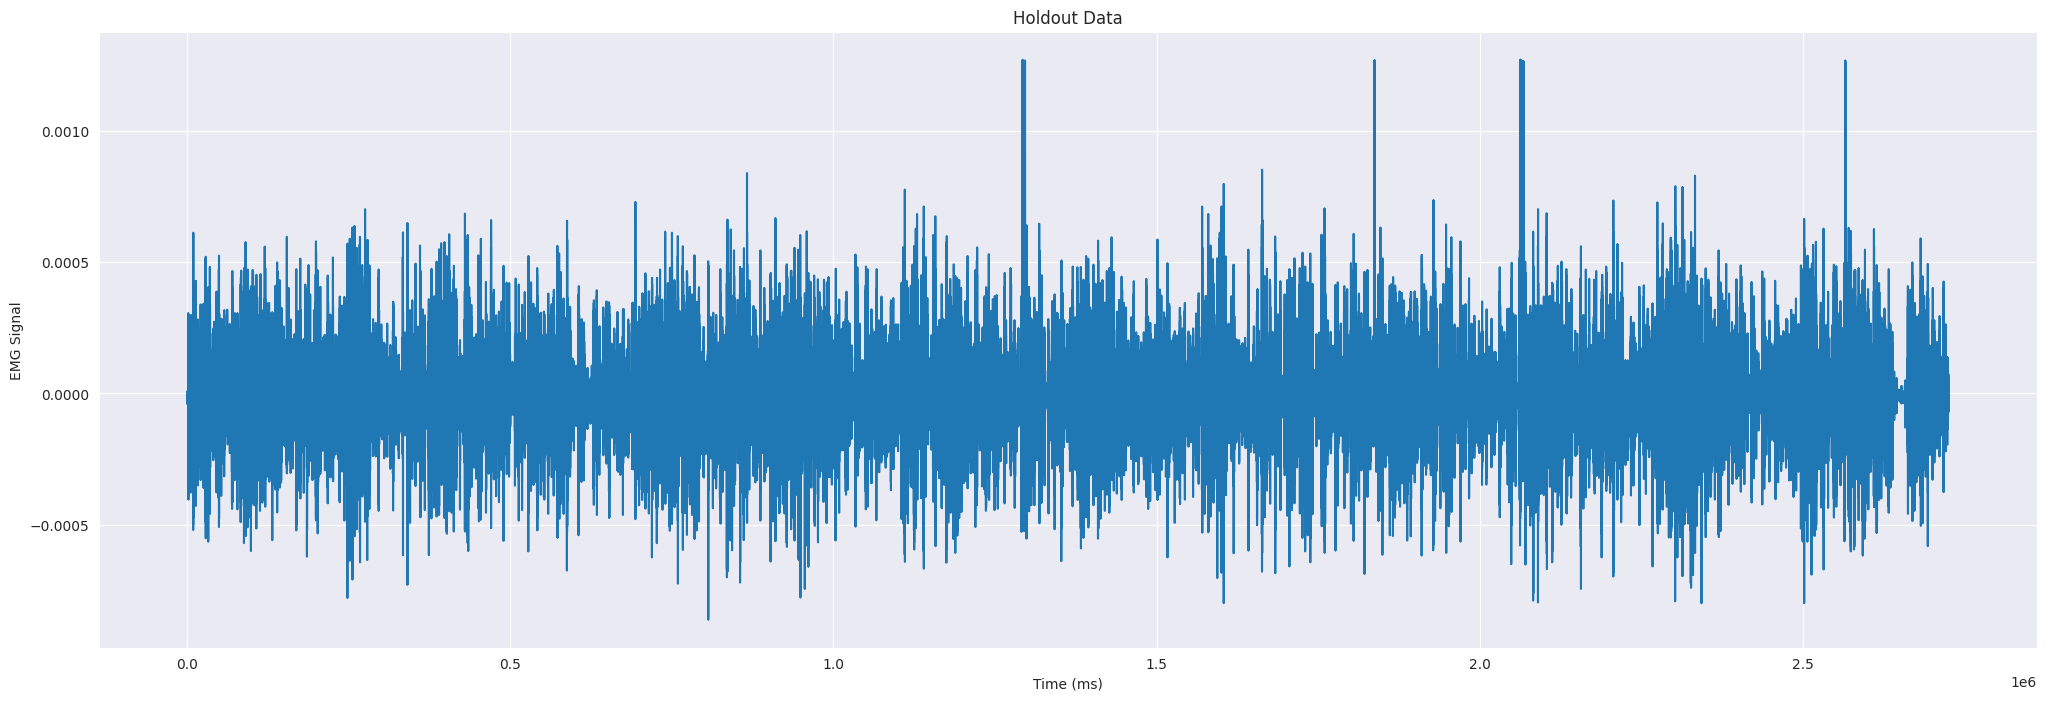

In [19]:
# Plot Holdout data
plt.figure(figsize=(25,8))
plt.plot(holdout_data[holdout_data['class'] == 0].iloc[:, 1:8].mean(axis=1))

# Add a legend and set the title and axis labels
plt.title('Holdout Data')
plt.xlabel('Time (ms)')
plt.ylabel('EMG Signal')
# Show the plot
plt.show()

### Train Test Split

The overall data is collected for 36 subjects, who perform a series of gestures with an interval of 3 seconds. These subjects perform these activities twice. For the sake of consistency, we will consider the first trial as our training data and the second trial as our test data. Also, the data contains unmarked gestures (class = 0), which we have separated out as holdout.

In [20]:
labeled_train = all_train.loc[all_train['class'] != 0]
labeled_train = labeled_train.reset_index(drop=True)

labeled_test = all_test.loc[all_test['class'] != 0]
labeled_test = labeled_test.reset_index(drop=True)

In [21]:
print("Labeled Train Shape: ", labeled_train.shape)
labeled_train

Labeled Train Shape:  (754690, 11)


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
1,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
2,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
3,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
4,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
...,...,...,...,...,...,...,...,...,...,...,...
754685,50226,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
754686,50227,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
754687,50228,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
754688,50229,0.00014,0.00003,-0.00001,0.00001,-0.00012,0.00006,-0.00007,-0.00013,6,36


In [22]:
labeled_test

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2400,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,1.0,1
1,2401,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
2,2402,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
3,2403,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
4,2404,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
758055,53577,0.00001,0.00000,-0.00002,0.00002,-0.00010,0.00004,-0.00003,-0.00004,6.0,36
758056,53578,0.00001,0.00000,-0.00002,0.00002,-0.00010,0.00004,-0.00003,-0.00004,6.0,36
758057,53579,0.00005,0.00002,0.00000,0.00000,-0.00005,-0.00005,-0.00004,-0.00001,6.0,36
758058,53580,0.00005,0.00002,0.00000,0.00000,-0.00005,-0.00005,-0.00004,-0.00001,6.0,36


#### Plot Data

In [23]:
def plot_labeled_data(df, str_title):
    # Create a dictionary of gestures and their corresponding colors
    gesture_colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'red', 5: 'purple', 6: 'brown', 7: 'pink'}

    plt.figure(figsize=(25,8))
    # Iterate through each gesture and plot it with a different color
    for gesture in gesture_colors:
        gesture_data = df[df['class'] == gesture].iloc[:, 1:8].mean(axis=1)
        plt.plot(gesture_data, color=gesture_colors[gesture], label=f'Gesture {gesture}')

    # Add a legend and set the title and axis labels
    plt.title(str_title)
    plt.xlabel('Time (ms)')
    plt.ylabel('EMG Signal')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()

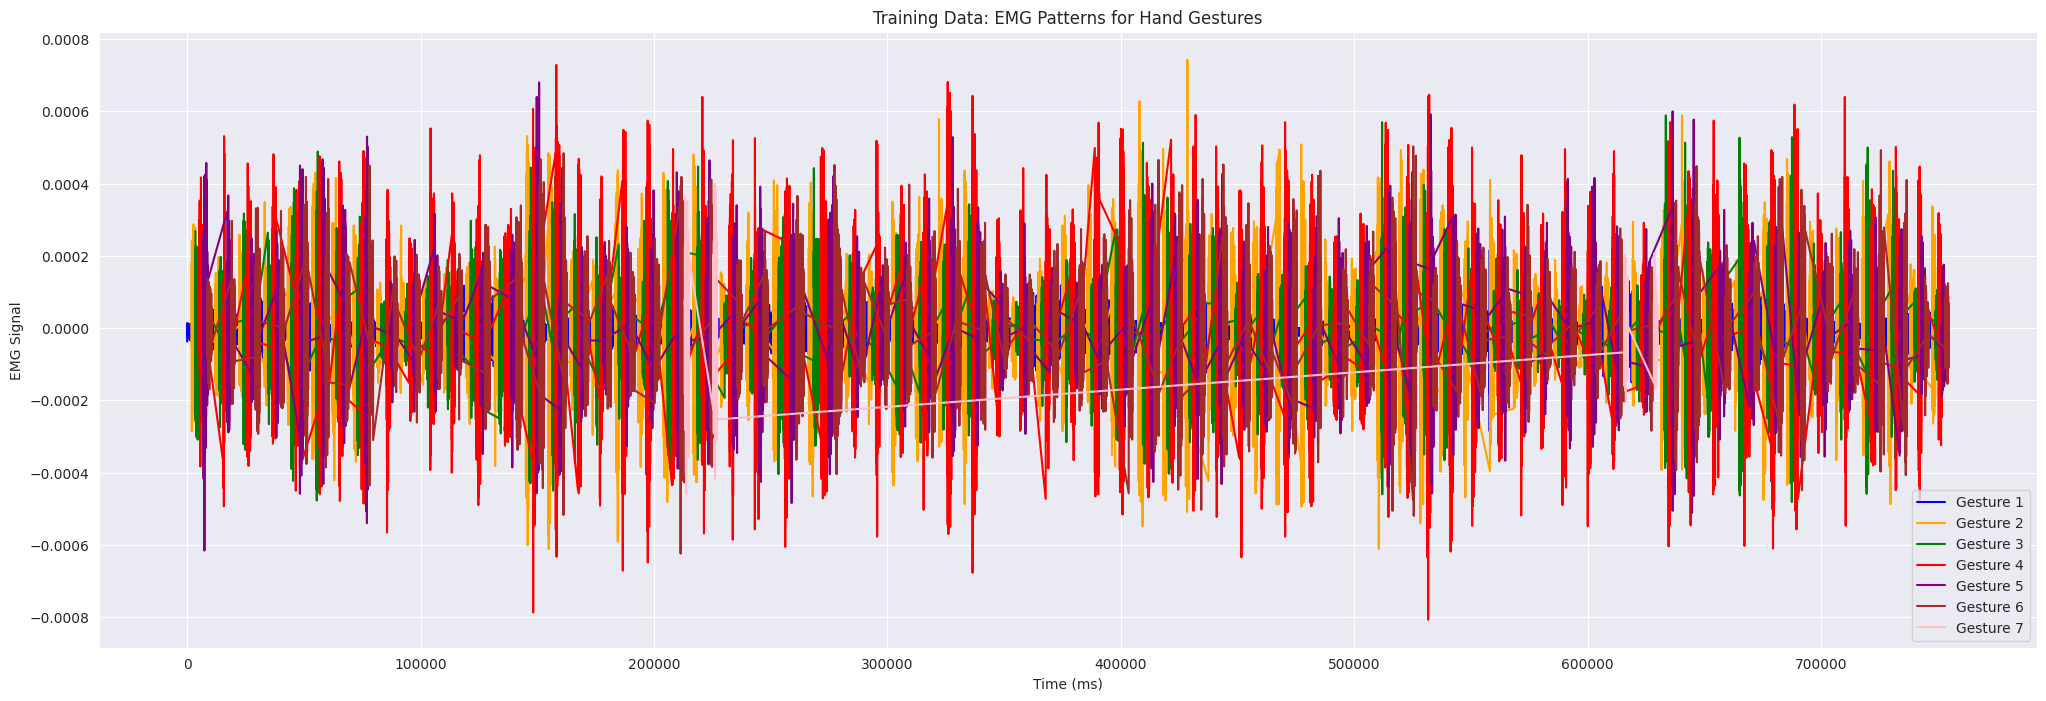

In [24]:
plot_labeled_data(labeled_train, 'Training Data: EMG Patterns for Hand Gestures')

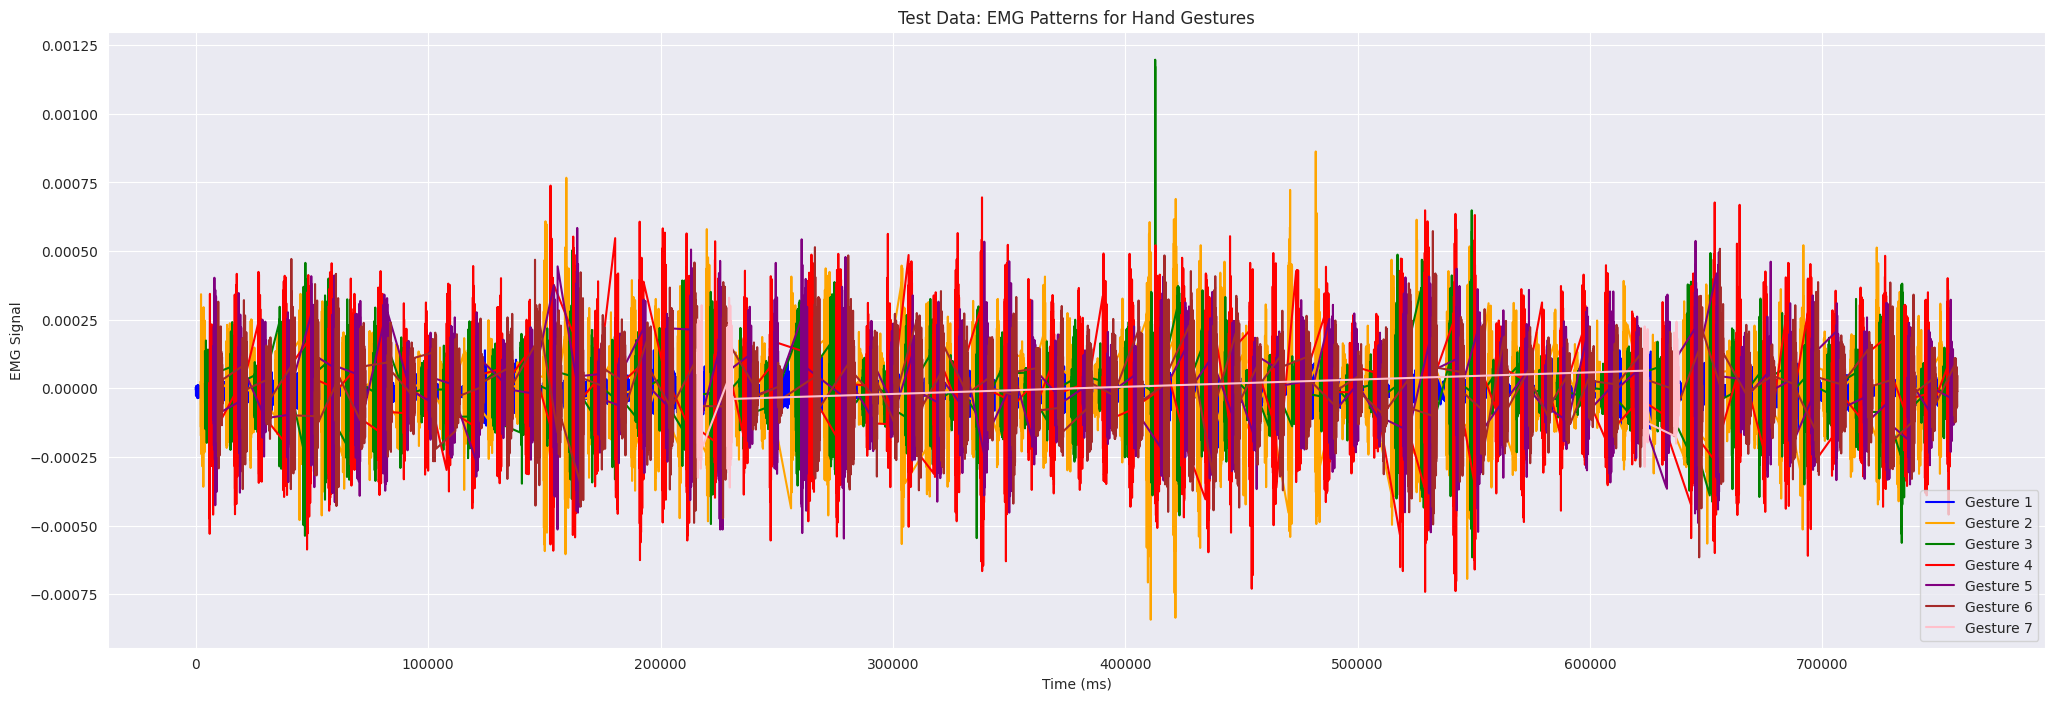

In [25]:
plot_labeled_data(labeled_test, 'Test Data: EMG Patterns for Hand Gestures')

In [26]:
print('Train Classes: ', labeled_train['class'].unique())
print('Test Classes: ', labeled_test['class'].unique())

Train Classes:  [1 2 3 4 5 6 7]
Test Classes:  [1. 2. 3. 4. 5. 6. 7.]


In [27]:
labeled_test.isna().sum()

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64

## Feature Engineering

Now, we have separated the train and test sets, so we will perform `catch22` feature engineering for extracting features that capture the overall pattern of activity across all the sensors. So, want to apply `catch22` to the entire data for each row.

In [28]:
def catch22_features(df, signal_interval=1024):
    catch22_list = []
    # iterate over each subject in the data
    for subject_id in df['subject_id'].unique():
        # iterate over each channel in the data
        for channel in range(1, 9):
            sub_df = df.loc[df['subject_id']==subject_id, f'channel{channel}']
            # split the data into intervals of length 1024
            intervals = np.array_split(sub_df, len(sub_df)//signal_interval)
            y_segments = np.array_split(df.loc[df['subject_id']==subject_id, 'class'], len(sub_df)//signal_interval)
            # for each signal interval
            for int_idx, interval in enumerate(intervals):
                # apply catch22 on the interval and compute the mean of all the features
                features_interval = pycatch22.catch22_all(interval)
                # compute more statistical features for the data of each channel
                interval_stats = {}
                class_mode = statistics.mode(y_segments[int_idx])
                interval_stats['class_mode'] = class_mode
                interval_stats['subject_id'] = subject_id
                interval_stats['channel'] = channel
                interval_stats['interval'] = int_idx
                # interval_stats['mean'] = np.mean(interval)
                # interval_stats['std'] = np.std(interval)
                # interval_stats['var'] = np.var(interval)
                # interval_stats['min'] = np.min(interval)
                # interval_stats['max'] = np.max(interval)    
                #interval_stats['ptp'] = np.ptp(interval)    
                #interval_stats['rms'] = np.sqrt(np.mean(interval**2))    
                interval_stats['skew'] = stats.skew(interval)    
                interval_stats['kurtosis'] = stats.kurtosis(interval)    
                # map feature names to feature values for each signal interval
                features_mean = {feature_name: feature_value for feature_name, feature_value in zip(features_interval['names'], features_interval['values'])}
                interval_dict = {**interval_stats, **features_mean}
                catch22_list.append(interval_dict)

    catch22_df = pd.DataFrame(catch22_list)
    return catch22_df

In [29]:
catch22_train = catch22_features(labeled_train)
catch22_train

,class_mode,subject_id,channel,interval,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,1,0,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,1,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,2,1,1,2,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,3,1,1,3,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,3,1,1,4,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,3,36,8,12,-0.471653,0.738986,-0.231182,0.554378,9.162435,30,0.784625,0.033045,0.099712,38.0,0.006669,122,0.221273,17.0,0.055556,-0.086207,-0.407088,0.898303,3.0,1.390511,0.604167,0.479167,0.110447,0.507381
5732,4,36,8,13,0.483267,1.226203,0.058428,-0.278044,9.677923,22,0.779792,0.065751,0.093960,51.0,0.003125,82,0.166129,21.0,0.038462,0.155172,0.048851,0.868697,3.0,1.393197,0.520833,0.562500,0.104311,0.538410
5733,5,36,8,14,0.228893,0.680643,0.419465,0.122728,7.804646,22,0.761313,-0.005493,0.108341,58.0,0.003945,36,0.167986,15.0,0.062500,-0.491379,-0.283525,0.886062,3.0,1.434484,0.416667,0.645833,0.153398,0.547807
5734,5,36,8,15,-0.540673,2.595853,0.320656,-0.047294,7.277011,17,0.617111,0.172848,0.099712,56.0,0.007292,60,0.128639,16.0,0.038462,0.525862,0.087165,0.861937,4.0,1.323310,0.520833,0.395833,0.116583,0.599501


In [30]:
catch22_train_512 = catch22_features(labeled_train,512)
catch22_train_256 = catch22_features(labeled_train,256)
#catch22_train_128 = catch22_features(labeled_train,128)

In [31]:
catch22_train.shape[0]+catch22_train_512.shape[0]+catch22_train_256.shape[0]

40832

In [32]:
catch22_train = pd.concat((catch22_train,catch22_train_512,catch22_train_256),axis=0)

In [33]:
catch22_test = catch22_features(labeled_test)
catch22_test

,class_mode,subject_id,channel,interval,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1.0,1,1,0,-0.203058,-0.545527,0.018504,0.270477,10.569761,46,0.942008,-0.081804,0.077661,68.0,0.004155,156,0.158986,25.0,0.037037,-0.005747,0.017241,0.914081,3.0,1.079347,0.500000,0.458333,0.085903,0.477245
1,1.0,1,1,1,-0.418770,-0.146674,-0.074151,0.158089,6.797859,16,0.899385,0.002669,0.084372,38.0,0.023244,25,0.166613,14.0,0.066667,-0.109195,0.560345,0.881859,3.0,1.185854,0.395833,0.333333,0.162602,0.577558
2,2.0,1,1,2,-0.876967,3.203998,-0.207673,0.206871,8.396841,23,0.609232,-0.013999,0.092042,73.0,0.003575,70,0.129834,18.0,0.050000,-0.252874,-0.812261,0.843965,3.0,1.383207,0.458333,0.416667,0.122718,0.596065
3,2.0,1,1,3,-0.118534,0.503527,0.478682,-0.437584,12.670202,24,0.806676,0.010292,0.087248,70.0,0.010582,31,0.163999,23.0,0.020833,-0.637931,-0.828544,0.902969,3.0,1.350090,0.375000,0.708333,0.079767,0.492917
4,3.0,1,1,4,-0.004600,-0.044157,0.651497,0.387987,10.409305,22,0.886702,-0.060302,0.084372,54.0,0.003658,105,0.163751,18.0,0.052632,-0.137931,0.200192,0.907584,3.0,1.334055,0.416667,0.458333,0.107379,0.501547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,3.0,36,8,13,-0.808155,1.066849,-0.379963,-0.083012,8.892756,22,0.689086,0.023114,0.107422,43.0,0.002848,78,0.206132,15.0,0.062500,0.031220,-0.013659,0.886854,3.0,1.409218,0.520833,0.437500,0.128854,0.533017
5780,4.0,36,8,14,-0.263410,-0.217338,0.108670,0.387976,6.643951,16,0.695987,-0.113564,0.100586,72.0,0.005942,36,0.151254,12.0,0.071429,0.002927,-0.094634,0.858080,3.0,1.418443,0.395833,0.395833,0.165670,0.601794
5781,5.0,36,8,15,-0.104150,1.536707,0.048547,0.341254,7.242392,22,0.688060,-0.176822,0.099609,66.0,0.009083,76,0.136931,14.0,0.066667,-0.363902,-0.471220,0.877859,3.0,1.376530,0.458333,0.520833,0.147262,0.569702
5782,5.0,36,8,16,-1.014367,4.668931,-0.329810,0.011238,7.202949,21,0.606460,0.009928,0.114258,60.0,0.004691,57,0.137026,12.0,0.071429,0.652683,0.845854,0.875835,3.0,1.430325,0.500000,0.375000,0.116583,0.567430


In [34]:
catch22_test_512 = catch22_features(labeled_test,512)
catch22_test_256 = catch22_features(labeled_test,256)
#catch22_test_128 = catch22_features(labeled_test,128)

In [35]:
catch22_test.shape[0]+catch22_test_512.shape[0]+catch22_test_256.shape[0]

41032

In [36]:
catch22_test = pd.concat((catch22_test,catch22_test_512,catch22_test_256),axis=0)

In [37]:
catch22_test.shape

(41032, 28)

In [38]:
X_train = catch22_train.drop('class_mode', axis=1)
y_train = catch22_train['class_mode']

X_test = catch22_test.drop('class_mode', axis=1)
y_test = catch22_test['class_mode']

In [39]:
print('DATA SPLITS \n1. Train: {} \n2. Test: {}'.format(X_train.shape, X_test.shape))

DATA SPLITS 
1. Train: (40832, 27) 
2. Test: (41032, 27)


In [40]:
X_train = X_train[y_train!=7]

In [41]:
y_train = y_train[y_train!=7]

In [42]:
y_train.shape

(40488,)

In [ ]:
# from sklearn.svm import SVC
# clf = SVC(kernel='linear')
# svm_model = clf.fit(X_train.values,y_train.values)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier()
# rf_model = clf.fit(X_train.values,y_train.values)

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier()
# gbr_model = clf.fit(X_train.values,y_train.values)

In [ ]:
# def getAccuracy(pred,actual):
#     correctClassifications = 0
#     for i in range(len(pred)):
#         if pred[i] == actual[i]:
#             correctClassifications += 1
#     return (correctClassifications/len(pred)) * 100

# def model_predict(model):
#     prediction_train = model.predict(X_train.values)
#     prediction_test = model.predict(X_test.values)
#     print("Train Accuracy: ", getAccuracy(prediction_train,y_train.values))
#     print("Test Accuracy: ", getAccuracy(prediction_test,y_test.values))

In [ ]:
# prediction_train = svm_model.predict(X_train.values)
# prediction_test = svm_model.predict(X_test.values)

In [ ]:
# getAccuracy(prediction_train,y_train.values)

In [ ]:
# getAccuracy(prediction_test,y_test.values)

In [ ]:
# model_predict(rf_model)

In [ ]:
# model_predict(gbr_model)

In [ ]:
# !pip install lazypredict

In [ ]:
# from lazypredict.Supervised import LazyClassifier

In [ ]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

In [ ]:
# Model                                                                          
# LGBMClassifier                     0.65               0.62    None      0.65   
# BaggingClassifier                  0.61               0.57    None      0.61   
# DecisionTreeClassifier             0.55               0.52    None      0.55   
# RandomForestClassifier             0.58               0.50    None      0.58   
# ExtraTreesClassifier               0.57               0.50    None      0.57   
# AdaBoostClassifier                 0.39               0.34    None      0.38   
# SVC                                0.37               0.32    None      0.36   
# ExtraTreeClassifier                0.35               0.31    None      0.35   
# NearestCentroid                    0.31               0.31    None      0.31   
# LogisticRegression                 0.35               0.30    None      0.33   
# CalibratedClassifierCV             0.35               0.30    None      0.33   
# LinearSVC                          0.35               0.30    None      0.31   
# RidgeClassifierCV                  0.35               0.30    None      0.30   
# RidgeClassifier                    0.35               0.30    None      0.30   
# LinearDiscriminantAnalysis         0.34               0.29    None      0.33   
# GaussianNB                         0.34               0.29    None      0.32   
# SGDClassifier                      0.31               0.27    None      0.30   
# KNeighborsClassifier               0.32               0.27    None      0.31   
# QuadraticDiscriminantAnalysis      0.31               0.27    None      0.31   
# PassiveAggressiveClassifier        0.31               0.26    None      0.28   
# Perceptron                         0.30               0.26    None      0.29   
# LabelSpreading                     0.28               0.24    None      0.28   
# LabelPropagation                   0.28               0.24    None      0.28   
# BernoulliNB                        0.28               0.24    None      0.24   
# DummyClassifier                    0.17               0.14    None      0.05   

In [ ]:
# catch22_df.to_csv('Segmented_Catch22_All.csv', index=False)

In [ ]:
# anova = catch22_df.groupby('class_mode').apply(lambda x: pd.Series(dict(zip(x.columns[5:], [stats.f_oneway(x[x['class_mode']==c][f], x[x['class_mode']!=c][f])[0] for f in x.columns[5:]])))).reset_index()
# anova = anova.melt(id_vars=['class_mode'], var_name='feature', value_name='f_value')
# top_features = anova.groupby('feature')['f_value'].mean().sort_values(ascending=False).index[:6].tolist()


In [ ]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm

# # Create a formula for ANOVA with class_mode as the target and all other numeric columns as predictors
# formula = 'class_mode ~ channel + interval + mean + std + min + max + DN_HistogramMode_5 + DN_HistogramMode_10 + CO_f1ecac + CO_FirstMin_ac + CO_HistogramAMI_even_2_5 + CO_trev_1_num + MD_hrv_classic_pnn40 + SB_BinaryStats_mean_longstretch1 + SB_TransitionMatrix_3ac_sumdiagcov + PD_PeriodicityWang_th0_01 + CO_Embed2_Dist_tau_d_expfit_meandiff + IN_AutoMutualInfoStats_40_gaussian_fmmi + FC_LocalSimple_mean1_tauresrat + DN_OutlierInclude_p_001_mdrmd + DN_OutlierInclude_n_001_mdrmd + SP_Summaries_welch_rect_area_5_1 + SB_BinaryStats_diff_longstretch0 + SB_MotifThree_quantile_hh + SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 + SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 + SP_Summaries_welch_rect_centroid + FC_LocalSimple_mean3_stderr'

# # Fit the ANOVA model using ols
# model = smf.ols(formula=formula, data=catch22_df).fit()

# # Get ANOVA table
# anova_table = sm.stats.anova_lm(model, typ=2)

# # Print ANOVA table
# print(anova_table)


In [ ]:
# anova_table[anova_table['PR(>F)'] <= 0.05].sort_values('PR(>F)', ascending=True)

In [ ]:
# def catch22_features(df):
#     # create an empty list to store catch22 features
#     catch22_list = []

#     # iterate over each record in the data and generate catch22 features
#     for index, row in df.iterrows():
#         features = pycatch22.catch22_all(row[1:9])
#         features_dict = dict(zip(features['names'], features['values']))
#         catch22_dict = {**row[0:11].to_dict(), **features_dict, 'index': index}
#         catch22_list.append(catch22_dict)

#     # concatenate all catch22 features into a single dataframe
#     catch22_df = pd.DataFrame(catch22_list)

#     # set the index of the dataframe to 'index' column
#     catch22_df.set_index('index', inplace=True)

#     # # save the catch22 features to a csv file
#     # catch22_df.to_csv("catch22_features.csv", index=True)

#     return catch22_df

In [ ]:
# # apply catch22 to training set
# X_train_features = catch22_features(X_train)
# X_train_features

In [ ]:
# # after
# print(' Feature Engineering on Train Set\n', '='*60)
# print(' Original Shape: ', X_train.shape)
# print(' Final Shape: ', X_train_features.shape)

# print('\n\n Feature Engineering on Test Set\n', '='*60)
# print(' Original Shape: ', X_test.shape)
# print(' Final Shape: ', X_test_features.shape)

In [ ]:
# X_train_features = X_train_features.drop(index=79894, axis=0)
# y_train = y_train.drop(index=79894, axis=0)
# X_train_features.isnull().sum()

In [ ]:
# def mean(X):
#     return np.mean(X, axis=1)
# def std(X):
#     return np.std(X, axis=1)
# def ptp(X):
#     return np.ptp(X, axis=1)
# def var(X):
#     return np.var(X, axis=1)
# def minim(X):
#     return np.min(X, axis=1)
# def maxim(X):
#     return np.max(X, axis=1)
# def argmin(X):
#     return np.argmin(X, axis=1)
# def argmax(X):
#     return np.argmax(X, axis=1)
# def rmse(X):
#     return np.sqrt(np.mean(X**2, axis=1))
# def abs_diff(X):
#     return np.sum(np.abs(np.diff(X, axis=1)),axis=1)
# def skewness(X):
#     return stats.skew(X, axis=1)
# def kurt(X):
#     return stats.kurtosis(X, axis=1)
# def entropy(X):
#     hist, _ = np.histogram(X, bins=256, density=True)
#     hist = hist[hist > 0]
#     result = -np.sum(hist * np.log2(hist))
#     return np.full(X.shape[0], result)
# def hyper_dimension(X):
#     n_samples, n_features = X.shape
#     result = np.sqrt(n_samples) * (n_features / np.sqrt(n_samples - 1))
#     return np.full(X.shape[0], result)
# def dwt_coeffs(X, wavelet='db4'):
#     coeffs = pywt.dwt(X, wavelet)
#     cA, cD = coeffs
#     return np.concatenate([cA.mean(axis=1), cD.mean(axis=1), cA.std(axis=1), cD.std(axis=1)])
# def spectrogram(X):
#     S = np.abs(librosa.stft(X))
#     return np.mean(librosa.power_to_db(S**2), axis=1)
# def mfcc(X, sr=22050, n_mfcc=20):
#     mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=n_mfcc)
#     return np.mean(mfccs, axis=1)

# def scalogram(X, wavelet='morl'):
#     scales = np.arange(1, 129)
#     coefs, freqs = pywt.cwt(X, scales, wavelet)
#     return np.abs(coefs)
# def fractal_dimension(X):
#     return np.array([dfa(x) for x in X])
# def lyapunov_exponent(X):
#     return np.array([np.nan] * len(X))
# def corr_dim(X):
#     return np.array([nolds.corr_dim(X[i], emb_dim=4, rvals='default')[0] for i in range(X.shape[0])])

# def concat_features(X):
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
#     features = [mean(X),
#                 std(X),
#                 ptp(X),
#                 var(X),
#                 rmse(X),
#                 abs_diff(X),
#                 skewness(X),
#                 kurt(X),
#                 entropy(X),
#                 ]
#     return np.vstack(features)

#                 # minim(X),
#                 # maxim(X),
#                 # argmin(X),
#                 # argmax(X),
#                 # hyper_dimension(X),
#                 # dwt_coeffs(X),
#                 # mfcc(X),
#                 # scalogram(X, wavelet='morl'),
#                 # fractal_dimension(X),
#                 # lyapunov_exponent(X),
#                 # corr_dim(X),
                

In [ ]:
# # Extract features for each channel
# col_names = []
# channel_features = []
# for i in range(8):
#     X = X_train[f"channel{i+1}"].values
#     channel_features.append(concat_features(X).T)
# print(len(channel_features))    

# # Pad the shorter feature arrays with zeros
# max_rows = max(len(arr) for arr in channel_features)
# for i in range(8):
#     num_rows = len(channel_features[i])
#     if num_rows < max_rows:
#         num_cols = channel_features[i].shape[1]
#         padding = np.zeros((max_rows - num_rows, num_cols))
#         channel_features[i] = np.concatenate([channel_features[i], padding], axis=0)
#     col_names.append([f"channel{i}_{feat}" for feat in ["mean", "std", "ptp", "var", "rmse", "abs_diff", "skewness", "kurt", "entropy"]])
    

# # Concatenate the features
# ffe_data = np.concatenate(channel_features, axis=1)
# all_chnls = [chnl for col in col_names for chnl in col]
# ffe_df = pd.DataFrame(ffe_data, columns=all_chnls)

# # Merge the feature dataframe with X_train
# merged_df = pd.concat([X_train.reset_index(drop=True), ffe_df], axis=1)
# print('Engineered Features: ', merged_df.shape)
# merged_df.head()

In [ ]:
# merged_df.to_csv('all_ext_features_data.csv', index=False)

## Classical Machine Learning Models

In [46]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
X_test = X_test[y_test!=7]
y_test = y_test[y_test!=7]
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_train.iloc[:,5:].values,y_train.values)
y_test_pred=clf.predict(X_test.iloc[:,5:].values)
f=f1_score(y_test,y_test_pred,average='macro') 
c=confusion_matrix(y_test,y_test_pred)
a=accuracy_score(y_test,y_test_pred)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

F1 Score
0.2603590610774074
Confusion Matrix
[[4292  500  654  468  494  560]
 [ 522 1376  990 1477  960 1203]
 [ 730 1269 1241 1319  995 1302]
 [ 452 1396 1125 1593  903 1219]
 [ 695 1311 1094 1388 1035 1285]
 [ 681 1353 1166 1364 1008 1236]]
Accuracy
0.2649793388429752


In [73]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train.iloc[:,5:].values,y_train.values)
y_test_pred=neigh.predict(X_test.iloc[:,5:].values)
f=f1_score(y_test,y_test_pred,average='macro') 
c=confusion_matrix(y_test,y_test_pred)
a=accuracy_score(y_test,y_test_pred)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

F1 Score
0.15832733966716558
Confusion Matrix
[[2161 1736 1249  973  620  229]
 [1707 1673 1350 1016  557  225]
 [1772 1829 1354 1073  630  198]
 [1768 1711 1381 1036  574  218]
 [1653 1805 1419 1101  606  224]
 [1767 1760 1407 1019  637  218]]
Accuracy
0.1733569460842188


In [43]:
from scipy.optimize import minimize,Bounds
from dataclasses import dataclass
@dataclass
class SoftMarginSVM:
  C : float

  def dualSVM(self, gramXy, alphas):
    return np.sum(alphas) - 0.5 * alphas.dot(alphas.dot(gramXy))

  def jacobian_dualSVM(self,gramXy,alphas):
    return np.ones(len(alphas)) - alphas.dot(gramXy)

  def fit(self,X,y):
    N,n_features = X.shape
    y_ = np.where(y<=0,-1,1)
    self.alphas = np.ones(N)
    bounds = Bounds(np.zeros(N),np.full(N,self.C))
    constraints = ({'type':'eq','fun':lambda a : -np.dot(a, y_),'jac':lambda a:-y_})

    Xy = X * y_[:,np.newaxis]
    gramXy = Xy.dot(Xy.T)

    slsqp = minimize(fun = lambda a : -self.dualSVM(gramXy,a),
                     x0=self.alphas,
                     jac = lambda a : -self.jacobian_dualSVM(gramXy,a),
                     bounds=bounds,
                     constraints=constraints,
                     method='SLSQP')
    
    self.alphas = slsqp.x
    self.w = np.sum((self.alphas[:,np.newaxis] * Xy),axis=0)
    epsilon = 1e-6
    self.supportVectors = X[ self.alphas > epsilon]
    self.supportLabels = y[ self.alphas > epsilon]

    b = []
    for i in range(len(self.supportLabels)):
      b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
      b.append(b_i)
        
    self.intercept = sum(b)/len(b)

  def sigmoid(self,z):
    sig = 1 / (1 + np.exp(-z))
    return sig

  def predict(self,X):
    sig = self.sigmoid(X.dot(self.w)+self.intercept)
    return sig

In [44]:
def normalizeTrain(X):
  trainingMean = np.mean(X,axis=0)
  trainingStd = np.std(X,axis=0)
  return (X - trainingMean)/trainingStd,trainingMean,trainingStd

def normalizeTest(X,trainingMean,trainingStd):
  return (X - trainingMean)/trainingStd

In [76]:
X_train.head()

,subject_id,channel,interval,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,0,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,1,1,2,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,1,1,3,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,1,1,4,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


In [49]:
from sklearn.model_selection import train_test_split
svm = SoftMarginSVM(C=1)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
X_train_normalized,trainMean,trainStd = normalizeTrain(X_train.iloc[:,4:].values)
X_test_normalized = normalizeTest(X_test.iloc[:,4:].values,trainMean,trainStd)
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else -1)
  X_Sample,_,y_Sample,_ = train_test_split(X_train_normalized,y_train_category.values,train_size=0.005,shuffle=True)
  svm.fit(X_Sample,y_Sample)
  probability_df = pd.DataFrame(svm.predict(X_test_normalized))
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)
predictions = category_probabilities.apply(lambda x : np.argmax(x)+1,axis=1)
f=f1_score(y_test,predictions,average='macro') 
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

F1 Score
0.16355987585694012
Confusion Matrix
[[3448 1969    0  753  798    0]
 [1265 3393    0  783 1087    0]
 [1481 3378    0  830 1167    0]
 [1263 3430    0  817 1178    0]
 [1434 3353    0  854 1167    0]
 [1448 3334    0  840 1186    0]]
Accuracy
0.2170651318378591


In [52]:
from randomForest import Node,DecisionTreeClf,RandomForestClf
dclf = DecisionTreeClf(max_depth=10)
dclf.fit(X_train.iloc[:,5:].values,y_train.values)
predictions = dclf.predict(X_test.iloc[:,5:])
f=f1_score(y_test,predictions,average='macro') 
c=confusion_matrix(y_test,predictions),
a=accuracy_score(y_test,predictions)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

TypeError: ignored

In [69]:
predictions = dclf.predict(X_test.iloc[:,5:].values)

In [71]:
f=f1_score(y_test,predictions,average='macro') 
c=confusion_matrix(y_test,predictions),
a=accuracy_score(y_test,predictions)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

F1 Score
0.2361461651627438
Confusion Matrix
(array([[3667,  609,  477,  665,  386, 1164],
       [ 515, 1189,  326, 1821,  373, 2304],
       [ 703, 1127,  501, 1745,  438, 2342],
       [ 452, 1178,  405, 1929,  331, 2393],
       [ 643, 1044,  459, 1827,  472, 2363],
       [ 647, 1142,  453, 1660,  447, 2459]]),)
Accuracy
0.25130362062180245


In [66]:
X_test.iloc[:,5:].head(20)

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,0.018504,0.270477,10.569761,46,0.942008,-0.081804,0.077661,68.0,0.004155,156,0.158986,25.0,0.037037,-0.005747,0.017241,0.914081,3.0,1.079347,0.500000,0.458333,0.085903,0.477245
1,-0.074151,0.158089,6.797859,16,0.899385,0.002669,0.084372,38.0,0.023244,25,0.166613,14.0,0.066667,-0.109195,0.560345,0.881859,3.0,1.185854,0.395833,0.333333,0.162602,0.577558
2,-0.207673,0.206871,8.396841,23,0.609232,-0.013999,0.092042,73.0,0.003575,70,0.129834,18.0,0.050000,-0.252874,-0.812261,0.843965,3.0,1.383207,0.458333,0.416667,0.122718,0.596065
3,0.478682,-0.437584,12.670202,24,0.806676,0.010292,0.087248,70.0,0.010582,31,0.163999,23.0,0.020833,-0.637931,-0.828544,0.902969,3.0,1.350090,0.375000,0.708333,0.079767,0.492917
4,0.651497,0.387987,10.409305,22,0.886702,-0.060302,0.084372,54.0,0.003658,105,0.163751,18.0,0.052632,-0.137931,0.200192,0.907584,3.0,1.334055,0.416667,0.458333,0.107379,0.501547
5,-0.561655,-0.260241,11.830972,22,0.742532,-0.003806,0.102589,67.0,0.018889,104,0.224569,21.0,0.029412,-0.623563,-0.030651,0.917795,4.0,1.374419,0.437500,0.312500,0.088971,0.467427
6,0.214467,0.483347,9.880382,35,0.812432,-0.045215,0.100671,60.0,0.000833,65,0.176906,20.0,0.047619,0.011494,0.166667,0.892859,3.0,1.401548,0.500000,0.479167,0.095107,0.518700
7,0.960386,0.705917,9.045995,22,0.893631,0.065996,0.091083,74.0,0.008331,55,0.189096,15.0,0.058824,0.583333,0.153257,0.904888,3.0,1.376666,0.500000,0.479167,0.116583,0.500047
8,0.296724,0.551687,8.655216,23,0.892646,-0.089548,0.094919,51.0,0.005251,44,0.170539,14.0,0.066667,-0.226054,-0.377395,0.887989,3.0,1.399165,0.416667,0.458333,0.128854,0.523252
9,-0.193571,0.107245,7.555047,22,0.692672,0.113767,0.101630,67.0,0.013125,35,0.133519,12.0,0.076923,-0.211686,-0.185824,0.881529,3.0,1.399960,0.395833,0.395833,0.150330,0.552547


In [ ]:
class LogisticRegression:
  
  def __init__(self,learningRate,maxIteration,tolerance,removeIndex=[],doNormalization=False,doStandardization=False):
    self.learningRate = learningRate
    self.maxIteration = maxIteration
    self.tolerance = tolerance
    self.removeIndex = removeIndex
    self.doNormalization = doNormalization
    self.doStandardization = doStandardization

  def normalize(self,X):
    self.trainingMean = np.mean(X,axis=0)
    self.trainingStd = np.std(X,axis=0)
    return (X - self.trainingMean)/self.trainingStd

  def normalizeTest(self,X):
    return (X - self.trainingMean)/self.trainingStd

  def standardize(self,X):
    self.trainMin = np.min(X,axis=0)
    self.trainMax = np.max(X,axis=0)
    self.trainRange = self.trainMax - self.trainMin
    return (X - self.trainMin)/self.trainRange

  def standardizeTest(self,X):
    return (X - self.trainMin)/self.trainRange

  def add_X0(self,X):
    return np.column_stack([np.ones(X.shape[0],dtype=np.float16),X])

  def sigmoid(self,z):
    sig = 1 / (1 + np.exp(-z))
    return sig

  def costFunction(self,X,y):
    sig = self.sigmoid(X.dot(self.w))
    # print(sig)
    loss = y * np.log(sig) + (1-y)*np.log(1-sig)
    cost = - np.sum(loss)
    return cost

  def gradient(self,X_train,y_train):
    sig = self.sigmoid(X_train.dot(self.w))
    # print(sig)
    grad = (sig-y_train).dot(X_train)
    return grad

  def gradientDescent(self,X_train,y_train):
    losses = []
    prevLoss = float('inf')
    for i in tqdm(range(self.maxIteration),colour='red'):
      self.w = self.w - self.learningRate * self.gradient(X_train,y_train)
      # break
      currentLoss = self.costFunction(X_train,y_train)
      diff_loss = np.abs(prevLoss - currentLoss)
      losses.append(currentLoss)

      if diff_loss < self.tolerance:
        print('Change in error below tolerance')
        break

      prevLoss = currentLoss

    #self.plot()

  def predict(self,X):
    if self.doNormalization:
      X = self.normalizeTest(X)
    if self.doStandardization:
      X = self.standardizeTest(X)
    X = self.add_X0(X)
    sig = self.sigmoid(X.dot(self.w))
    return sig

  def fit(self,X_train,y_train):
    if self.doNormalization:
      X_train = self.normalize(X_train)
    if self.doStandardization:
      X_train = self.standardize(X_train)
    X_train = self.add_X0(X_train)
    self.w = np.ones(X_train.shape[1],dtype=np.float16)
    print('Solving using gradient Descent')
    self.gradientDescent(X_train,y_train)

    # print('Evaluate the training results')

    # self.plot()
    # self.scatterPlt()
    # self.plot3D()

  def evaluateFunction(self,y,y_hat): 
    y = ( y==1 )
    y_hat = (y_hat == 1)
    precision = (y & y_hat).sum()/y_hat.sum()
    recall = (y & y_hat).sum()/y.sum()
    f1_score = 2*(precision*recall)/(precision+recall)

    return recall,precision,f1_score
      
  def plot(self):
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')

    # Data for three-dimensional scattered points
    ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1], 
    self.sigmoid(self.X_train.dot(self.w)), 
    c = self.y_train[:], cmap='viridis', s=100);

    ax.set_xlim3d(55, 80)
    ax.set_ylim3d(80, 240)
    plt.xlabel('$x_1$ feature', fontsize=15)
    plt.ylabel('$x_2$ feature', fontsize=15, )
    ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    
    
  def scatterPlt(self):
    # evenly sampled points
    x_min, x_max = 55, 80
    y_min, y_max = 80, 240

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = grid.dot(self.w).reshape(xx.shape)

    f, ax = plt.subplots(figsize=(14,12))


    ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


    ax.scatter(self.X_train[:, 0], self.X_train[:, 1],c=self.y_train[:], s=50,cmap="RdBu", vmin=-.2, vmax=1.2,edgecolor="white", linewidth=1)

    plt.xlabel('x1 feature')
    plt.ylabel('x2 feature')
        

  def plot3D(self):
  # evenly sampled points
    x_min, x_max = 55, 80
    y_min, y_max = 80, 240
        
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = grid.dot(self.w).reshape(xx.shape)
    fig = plt.figure(figsize=(14,12))
    ax = plt.axes(projection='3d')
    ax.contour3D(xx, yy, probs, 50, cmap='binary')

    ax.scatter3D(self.X_train[:, 0], self.X_train[:, 1],c=self.y_train[:], s=50,cmap="RdBu", vmin=-.2, vmax=1.2,edgecolor="white", linewidth=1)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('probs')
    ax.set_title('3D contour')
    plt.show()

In [ ]:
y_train.unique()

array([1, 2, 3, 4, 5, 6])

In [72]:
X_train.head()

,subject_id,channel,interval,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,0,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,1,1,2,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,1,1,3,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,1,1,4,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


In [ ]:
X_train.iloc[:,5:].head()

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


In [ ]:
X_train.shape[0] - 344

40144

In [ ]:
X_train.shape

(40488, 27)

In [ ]:
X_test = X_test[y_test!=7]
y_test = y_test[y_test!=7]

In [ ]:
lr = LogisticRegression(tolerance=0.0001,learningRate=0.1e-05,maxIteration=10000,doStandardization=True)
unique_y = y_train.unique()
category_probabilities = pd.DataFrame()
for category in unique_y:
  y_train_category = y_train.map(lambda x : 1 if x == category else 0)
  lr.fit(X_train.iloc[:,5:].values,y_train_category.values)
  probability_df = pd.DataFrame(lr.predict(X_test.iloc[:,5:].values))
  category_probabilities = pd.concat((category_probabilities,probability_df),axis=1)

Solving using gradient Descent


100%|██████████| 10000/10000 [01:14<00:00, 133.98it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [01:16<00:00, 131.49it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [01:18<00:00, 126.60it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [01:16<00:00, 131.07it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [01:17<00:00, 128.90it/s]


Solving using gradient Descent


100%|██████████| 10000/10000 [01:14<00:00, 134.03it/s]


In [ ]:
category_probabilities.shape

(40656, 6)

In [ ]:
category_probabilities

,0,0,0,0,0,0
0,0.273567,0.150290,0.163416,0.219273,0.189968,0.195965
1,0.276375,0.153992,0.142431,0.143222,0.148389,0.145270
2,0.127820,0.153719,0.190337,0.170705,0.183187,0.219265
3,0.086678,0.130059,0.166006,0.190513,0.182842,0.210442
4,0.194528,0.145045,0.151165,0.154655,0.162709,0.165778
...,...,...,...,...,...,...
40651,0.100081,0.172236,0.154599,0.178930,0.155872,0.148047
40652,0.139815,0.160426,0.148026,0.128575,0.144300,0.165227
40653,0.157500,0.194031,0.208649,0.126909,0.181198,0.186756
40654,0.129108,0.151988,0.155047,0.164399,0.159729,0.174001


In [ ]:
predictions = category_probabilities.apply(lambda x : np.argmax(x)+1,axis=1)

NameError: ignored

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
f=f1_score(y_test,predictions,average='macro') 
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

F1 Score
0.21258146466621955
Confusion Matrix
[[4363  431  352  894   92  836]
 [1306  909  537 2063  234 1479]
 [1602  805  533 1982  246 1688]
 [1058  976  520 2295  225 1614]
 [1475  832  605 2089  247 1560]
 [1297  886  644 2073  252 1656]]
Accuracy
0.24603994490358128


In [ ]:
y_train.shape

(40488,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_svm,_,y_train_svm,__ = train_test_split(X_train,y_train,shuffle=True,train_size=0.03,random_state=1024)

In [ ]:
X_train_svm.shape

(1214, 27)

In [ ]:
from sklearn.svm import SVC

svc=SVC(C=100,kernel='poly',gamma=0.01,decision_function_shape='ovo',tol=0.1)
svc.fit(X_train_svm.iloc[:,5:].values,y_train_svm.values)
y_test_pred=svc.predict(X_test.iloc[:,5:].values)
f=f1_score(y_test,predictions,average='macro') 
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
f=f1_score(y_test,predictions,average='macro') 
c=confusion_matrix(y_test,predictions)
a=accuracy_score(y_test,predictions)
print('F1 Score')
print(f)
print('Confusion Matrix')
print(c)
print('Accuracy')
print(a)

## Deep Learning - Modeling

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

In [ ]:
# Convert y_train to categorical
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

# Set model input-output nodes
input_shape = X_train.shape[1]
output_shape = y_train_cat.shape[1]

In [ ]:
# Define hyperparameters
epochs = 128
batch_size = 64
learning_rate = 0.001
decay = 1e-6

In [ ]:
def train_loop(model, early_stopping=True):
    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(X_train.values, y_train_cat,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test_cat),
                        callbacks=[early_stop])
    else:
        history = model.fit(X_train.values, y_train_cat,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test_cat))

    return history

In [ ]:
def model_perf_plots(history, train_acc, val_acc):

    fig, axs = plt.subplots(2, 1, figsize=(8,12))
    # Plot train and validation accuracy
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')
    
    # Plot train and validation accuracy
    axs[1].plot(history.history[train_acc])
    axs[1].plot(history.history[val_acc])
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


### Neural Networks

In [ ]:
def neural_network(learning_rate, decay):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    opt = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-8)
    model.compile(loss='mse',
                    optimizer=opt,
                    metrics=['mse', 'accuracy'])

    model.summary()
    return model

In [ ]:
nn_model = neural_network(learning_rate, decay)
history_nn = train_loop(nn_model)
model_perf_plots(history_nn, 'accuracy', 'val_accuracy')

### Multi Layer Perceptron

In [ ]:
def multilayer_perceptron(learning_rate, decay):
    # Create model
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=input_shape))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))

    # Compile model
    opt = Adam(lr=learning_rate, decay=decay)
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=[categorical_accuracy])

    model.summary()
    return model

In [ ]:
mlp_model = multilayer_perceptron(learning_rate, decay)
history_mlp = train_loop(mlp_model, early_stopping=True)
model_perf_plots(history_mlp, 'categorical_accuracy', 'val_categorical_accuracy')

### Observations

In [ ]:
# create copies of original train, test data
lbl_train = labeled_train.copy(deep=True)
lbl_test = labeled_test.copy(deep=True)


In [ ]:
lbl_train.head()

## Temporal Transformation

In [ ]:
from keras.utils import to_categorical
data = np.array(lbl_train)
X = data[:, 1:9]
y = data[:, 9] - 1 # subtract 1 from each value in y
num_time_steps = 100
num_features = 8
num_samples = len(data) // num_time_steps
X = X[:num_samples * num_time_steps, :]
X = X.reshape(num_samples, num_time_steps, num_features)
y = y[:num_samples * num_time_steps]
y = y.reshape(num_samples, num_time_steps)

# This will create a new tensor y of shape (num_samples, num_time_steps, num_classes) 
# where each class label is represented as a binary vector of length 7.
y = to_categorical(y, num_classes=7)


print('Transformed X Shape: ', X.shape)
print('Transformed Y Shape: ', y.shape)


In [ ]:
X[:10,1,:]

In [ ]:
y[:10,1,:]

In [ ]:
print(num_features)

## Recurrent Neural Network (RNN)

In [ ]:
from keras.layers import SimpleRNN

# Define the RNN model architecture
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(num_time_steps, num_features)))
model.add(Dense(units=7, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

In [ ]:
# Train the model
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)

## LSTM

### Basic LSTM

In [ ]:
from keras.layers import LSTM
from keras.layers import Reshape

# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(num_time_steps, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.add(Reshape((num_time_steps, 7)))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary)

# Train the model
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


In [ ]:
# Test the model
test_data = np.array(lbl_test)
test_X = test_data[:, 1:9]
test_y = test_data[:, 9] - 1 # subtract 1 from each value in y
num_time_steps = 100
num_features = 8
num_samples = len(test_data) // num_time_steps
test_X = test_X[:num_samples * num_time_steps, :]
test_X = test_X.reshape(num_samples, num_time_steps, num_features)
test_y = test_y[:num_samples * num_time_steps]
test_y = test_y.reshape(num_samples, num_time_steps)
test_y = to_categorical(test_y, num_classes=7)

loss, accuracy = model.evaluate(test_X, test_y, batch_size=64)
print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)


### Advanced LSTM

In [ ]:
from keras.layers import LSTM
from keras.layers import Reshape, Flatten

# Build the model
model = Sequential()
model.add(LSTM(256, input_shape=(num_time_steps, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_time_steps * 7, activation='softmax'))
model.add(Reshape((num_time_steps, 7)))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
model.fit(X, y, epochs=50, batch_size=128, validation_split=0.2)

# Test the model
test_data = np.array(lbl_test)
test_X = test_data[:, 1:9]
test_y = test_data[:, 9] - 1 # subtract 1 from each value in y
num_time_steps = 100
num_features = 8
num_samples = len(test_data) // num_time_steps
test_X = test_X[:num_samples * num_time_steps, :]
test_X = test_X.reshape(num_samples, num_time_steps, num_features)
test_y = test_y[:num_samples * num_time_steps]
test_y = test_y.reshape(num_samples, num_time_steps)
test_y = to_categorical(test_y, num_classes=7)

loss, accuracy = model.evaluate(test_X, test_y, batch_size=128)
print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)
